# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [1]:
from unityagents import UnityEnvironment

import os
import numpy as np

# please do not modify the line below
# env = UnityEnvironment(file_name=os.path.join(".", "data", "Banana.exe"))
env = UnityEnvironment(file_name="./data/Banana.exe", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

### Training phase

Now we are going to train an agent using a very similar Deep Q-Network that we used in the lunarlander-v2 in the openAI gym exercise. In order to create a simpler estructure to our code, we are going to create a training function first.

In [5]:
from collections import deque

import numpy as np
import torch

def dqn(agent, env, brain_name, n_episodes=2000, n_steps_episode = 3000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, reward_threshold = 12):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        for t in range(n_steps_episode):
            action = agent.act(state, eps).astype(np.int32)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            score += reward            
            if done:
                break
            agent.step(state, action, reward, next_state, done) #add the tuple (s, a, r, s', d) to the memory of the agent
            state = next_state
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=reward_threshold:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

Now we add some methods to visualize the results and understand how the agent improves itself.

In [15]:
def moving_average(array, n=3) :
    cumsum = np.cumsum(array, dtype=float)
    cumsum[n:] = cumsum[n:] - cumsum[:-n]
    return cumsum[n - 1:] / n


def average_last_samples(array, n = 100):
    array = np.array(array)
    avg = []
    for i in range(len(array)):
        min_idx = max(0, i - n)
        avg.append(array[min_idx:i].mean())
    return avg        


def show_scores(scores, threshold_value):
    plt.figure(figsize = (10, 8))
    plt.plot(scores, ".", color = "k", label = "score")
    plt.plot(average_last_samples(scores), "-", color = "r", label = "Last 100 steps")
    plt.plot(moving_average(scores), "-", color = "b", label = "Moving average (3 steps size)")
    plt.axhline(y = threshold_value, color = "g", linestyle = "-.", label = "Avg last 100 steps reward threshold")
    plt.title("Rewards history during training")
    plt.legend()
    plt.show()

Creating the environment and the variables needed to define our state and action spaces.

In [3]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="./data/Banana.exe", no_graphics=True)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


QNetwork(
  (hiddens): ModuleList(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
  (activation): ReLU()
)
Episode 100	Average Score: 0.46
Episode 200	Average Score: 3.77
Episode 300	Average Score: 7.32
Episode 400	Average Score: 9.86
Episode 500	Average Score: 12.45
Episode 600	Average Score: 13.63
Episode 700	Average Score: 14.88
Episode 719	Average Score: 15.01
Environment solved in 619 episodes!	Average Score: 15.01


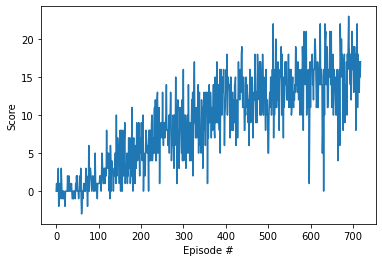

In [6]:
from dqn_agent import Agent

import matplotlib.pyplot as plt

parameters_dict = {
    "buffer_size": int(1e5),
    "batch_size": 64,
    "gamma": 0.99,
    "tau": 1e-3,
    "lr": 5e-4,
    "update_every": 4,
    "nhidden": [64, 32]
}

reward_threshold = 15
agent = Agent(state_size = state_size, action_size = action_size, seed = 0, **parameters_dict)
print(agent.qnetwork_local)
scores = dqn(agent, env, brain_name, reward_threshold = reward_threshold)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

C:\Users\ilberto\anaconda3\envs\dlrnd\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':
C:\Users\ilberto\anaconda3\envs\dlrnd\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


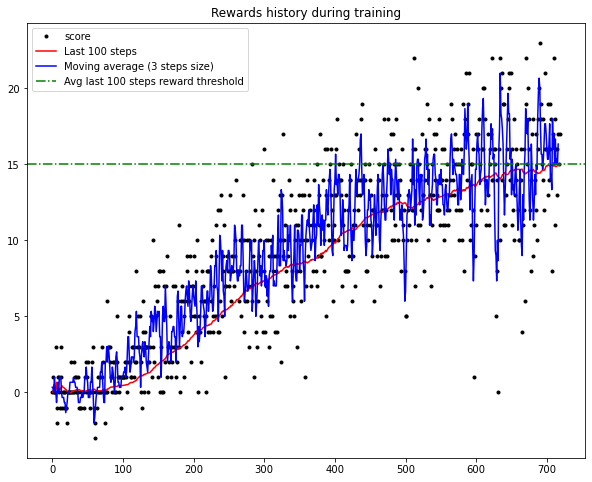

In [16]:
show_scores(scores, reward_threshold)